# Keras functional API

Introduction

The Keras functional API is a way to create models that is more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, models with shared layers, and models with multiple inputs or outputs.

The main idea that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers

In [1]:
#Preparation of the model environment

from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
#start by creating an input node:

inputs = keras.Input(shape=(784,)) #784-dimensional vector. The batch size is always omitted since only the shape of each sample is specified.

#or:

img_inputs = keras.Input(shape=(32, 32, 3)) #image input with a shape of (32, 32, 3)

We can check shape and dtype

In [3]:
inputs.shape

TensorShape([None, 784])

In [4]:
img_inputs.shape

TensorShape([None, 32, 32, 3])

In [5]:
inputs.dtype

tf.float32

In [6]:
img_inputs.dtype

tf.float32

You create a new node in the graph of layers by calling a layer on this inputs object:

In [0]:
dense = layers.Dense(64, activation='relu')
x = dense(inputs)

Let's add a few more layers to the graph of layers:

In [0]:
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

create a Model by specifying its inputs and outputs in the graph of layers

In [9]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


You can also plot the model as a graph:

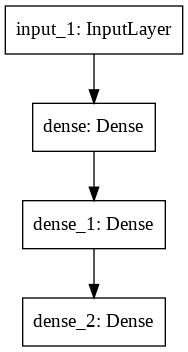

In [10]:
keras.utils.plot_model(model)


And display the input and output shapes of each layer in the plotted graph:

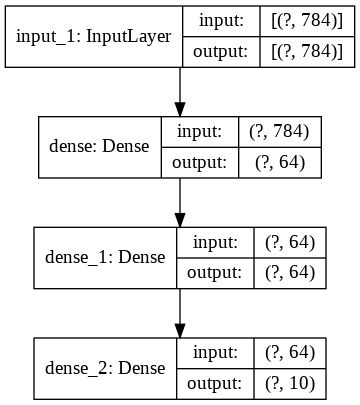

In [11]:
keras.utils.plot_model(model, show_shapes=True)


Training, evaluation, and inference

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


11493376/11490434 [==============================] - 0s 0us/step
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 59us/sample - loss: 0.3500 - accuracy: 0.9000 - val_loss: 0.2133 - val_accuracy: 0.9374
Epoch 2/5
48000/48000 [==============================] - 2s 43us/sample - loss: 0.1661 - accuracy: 0.9510 - val_loss: 0.1483 - val_accuracy: 0.9574
Epoch 3/5
48000/48000 [==============================] - 2s 42us/sample - loss: 0.1222 - accuracy: 0.9635 - val_loss: 0.1313 - val_accuracy: 0.9613
Epoch 4/5
48000/48000 [==============================] - 2s 44us/sample - loss: 0.0975 - accuracy: 0.9710 - val_loss: 0.1262 - val_accuracy: 0.9644
Epoch 5/5
48000/48000 [==============================] - 2s 43us/sample - loss: 0.0814 - accuracy: 0.9761 - val_loss: 0.1125 - val_accuracy: 0.9679
10000/10000 - 0s - loss: 0.1086 - accuracy: 0.9665
Test loss: 0.1085853345265612
Test accuracy: 0.9665


Use the same graph of layers to define multiple models (composition principle)

In [13]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img') #common input for both models

x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x) #first output

encoder = keras.Model(encoder_input, encoder_output, name='encoder') #first model
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x) #second output

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

All models are callable, just like layers

In [14]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

Ensembling

In [17]:
def get_model():
  inputs = keras.Input(shape=(128,))
  outputs = layers.Dense(1)(inputs)
  return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3]) #single model that averages predictions on three models
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 1)            129         input_14[0][0]                   
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            129         input_14[0][0]                   
__________________________________________________________________________________________________
model_10 (Model)                (None, 1)            129         input_14[0][0]                   
___________________________________________________________________________________________

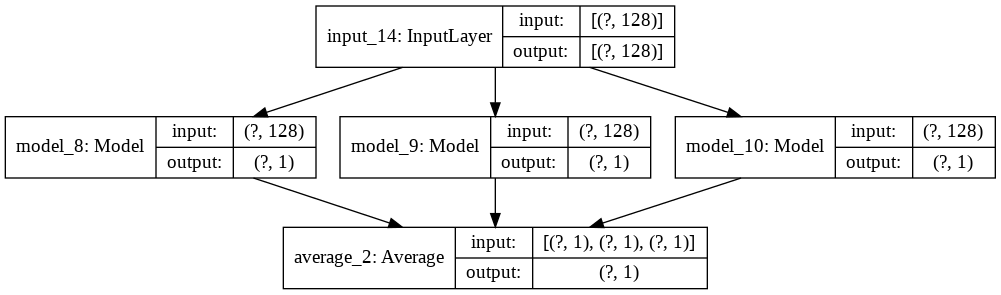

In [18]:
keras.utils.plot_model(ensemble_model, show_shapes=True)

#Manipulating complex graph topologies

Models with multiple inputs and outputs

system for ranking custom issue tickets by priority and routing them to the correct department, then the model will have three inputs:

    the title of the ticket (text input),
    the text body of the ticket (text input), and
    any tags added by the user (categorical input)

This model will have two outputs:

    the priority score between 0 and 1 (scalar sigmoid output), and
    the department that should handle the ticket (softmax output over the set of departments).


In [0]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name='priority')(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])


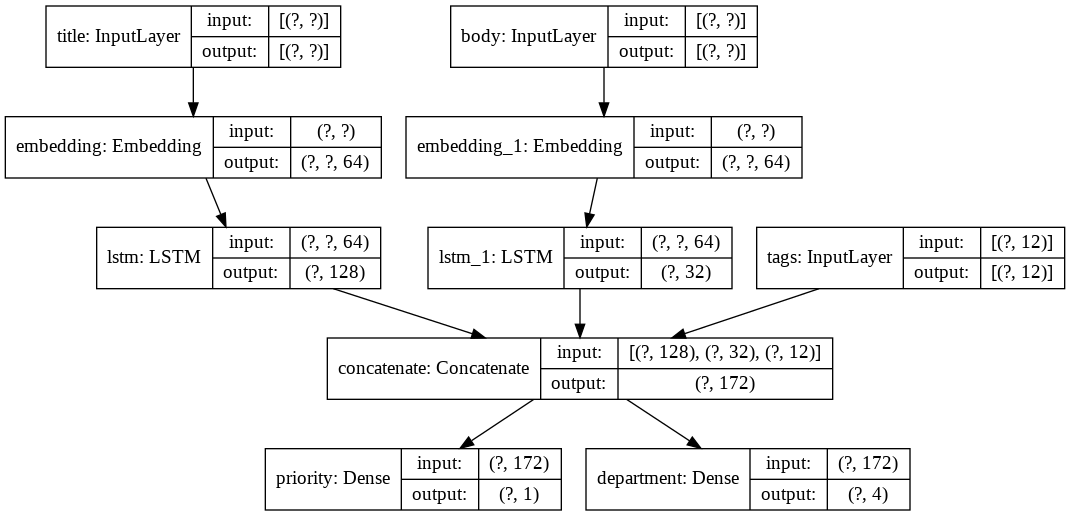

In [20]:
keras.utils.plot_model(model, show_shapes=True)


It is possible to assign different losses to each output. Also to assign different weights to each loss—to modulate their contribution to the total training loss.

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=[keras.losses.BinaryCrossentropy(from_logits=True),
                    keras.losses.CategoricalCrossentropy(from_logits=True)],
              loss_weights=[1., 0.2])
# or

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'priority':keras.losses.BinaryCrossentropy(from_logits=True),
                    'department': keras.losses.CategoricalCrossentropy(from_logits=True)},
              loss_weights=[1., 0.2])


In [23]:
# Training the model

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit({'title': title_data, 'body': body_data, 'tags': tags_data},
          {'priority': priority_targets, 'department': dept_targets},
          epochs=2,
          batch_size=32)

Train on 1280 samples
Epoch 1/2
1280/1280 [==============================] - 4s 3ms/sample - loss: 1.3740 - priority_loss: 0.7027 - department_loss: 3.3566
Epoch 2/2
1280/1280 [==============================] - 2s 1ms/sample - loss: 1.3508 - priority_loss: 0.7003 - department_loss: 3.2526


In [0]:
#When calling fit with a Dataset object, it should yield either a tuple of lists 
#like ([title_data, body_data, tags_data], [priority_targets, dept_targets]) 
#or a tuple of dictionaries like ({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets}).